In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [4]:
import numpy as np 
from operators.setup_FOM_two_stream import SimulationSetupTwoStreamFOM
from operators.FOM import total_mass, total_momentum, total_energy_k, psi_ln_aw
import scipy

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Two stream instability singular value decomposition

In [8]:
setup = SimulationSetupTwoStreamFOM(Nx=251,
                                    Nv=250,
                                    epsilon=0.1,
                                    alpha_e1=0.5,
                                    alpha_e2=0.5,
                                    alpha_i=np.sqrt(2 / 1836),
                                    u_e1=-1,
                                    u_e2=1,
                                    u_i=0,
                                    L=2 * np.pi,
                                    dt=1e-2,
                                    T0=0,
                                    T=40,
                                    nu_e1=15,
                                    nu_e2=15,
                                    n0_e1=0.5,
                                    n0_e2=0.5,
                                    construct_B=False)

In [9]:
# velocity grid for plotting purposes
v = np.linspace(-4, 4, int(10**4))
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)

In [23]:
# number of moments to solve for M
M = 5

In [24]:
sol_midpoint_u = np.load("../data/FOM/two_stream/sample_1/sol_FOM_u_" + str(setup.Nv) + "_nu_" + str(setup.nu_e1) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../data/FOM/two_stream/sample_1/sol_FOM_t_" + str(setup.Nv) + "_nu_" + str(setup.nu_e1) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

In [25]:
sol_midpoint_e1 = sol_midpoint_u[M*setup.Nx:setup.Nx*setup.Nv, :]
sol_midpoint_e2 = sol_midpoint_u[setup.Nv*setup.Nx+M*setup.Nx:, :]

In [26]:
# compute the SVD
# electrons species (1)
U_e1, S_e1, _ = np.linalg.svd(sol_midpoint_e1, full_matrices=False)
print("e1 SVD computed!")

e1 SVD computed!


In [27]:
# electrons species (2)
U_e2, S_e2, _ = np.linalg.svd(sol_midpoint_e2, full_matrices=False)
print("e2 SVD computed!")

e2 SVD computed!


In [28]:
# basis save first 1000 modes (we dont really use more than that)
np.save("../data/ROM/two_stream/basis_SVD_e1_" + str(setup.T0) + "_" + str(setup.T) + "_M_" + str(M) + ".npy", U_e1[:, :1000])
np.save("../data/ROM/two_stream/basis_SVD_e2_" + str(setup.T0) + "_" + str(setup.T) + "_M_" + str(M) + ".npy", U_e2[:, :1000])

In [29]:
# singular values
np.save("../data/ROM/two_stream/singular_values_SVD_e1_" + str(setup.T0) + "_" + str(setup.T) + "_M_" + str(M) + ".npy", S_e1)
np.save("../data/ROM/two_stream/singular_values_SVD_e2_" + str(setup.T0) + "_" + str(setup.T) + "_M_" + str(M) + ".npy", S_e2)

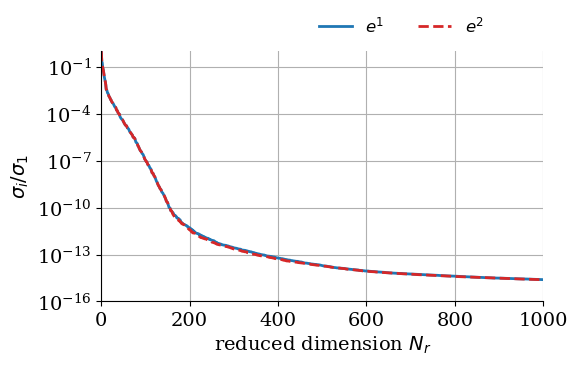

In [30]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(len(S_e1)), (np.abs(S_e1)/np.max(S_e1[0])), color="tab:blue",linewidth=2, label=r"$e^{1}$")
ax.plot(np.arange(len(S_e2)), (np.abs(S_e2)/np.max(S_e2[0])), ls="--", color="tab:red", linewidth=2, label=r"$e^{2}$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\sigma_{i}/\sigma_{1}$")
ax.set_xlabel(r"reduced dimension $N_{r}$")
ax.set_yscale("log")
ax.set_ylim(10**-16, 1)
ax.set_xlim(0, 1000)
plt.grid()

legend = ax.legend(ncols=3, fancybox=False, shadow=False, fontsize=12, loc='upper right', bbox_to_anchor=(0.9, 1.2))
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/linear_landau/singular_value_decay_linear_landau_M" + str(M) + ".png", dpi=300, bbox_inches='tight')

In [36]:
U_e1_tensor = np.zeros((setup.Nv - M, setup.Nx, np.shape(U_e1)[-1]))
U_e2_tensor = np.zeros((setup.Nv - M, setup.Nx, np.shape(U_e2)[-1]))

for n in range(0, setup.Nv - M):
    U_e1_tensor[n, :, :] = U_e1[n*setup.Nx: (n+1)*setup.Nx, :]
    U_e2_tensor[n, :, :] = U_e2[n*setup.Nx: (n+1)*setup.Nx, :]

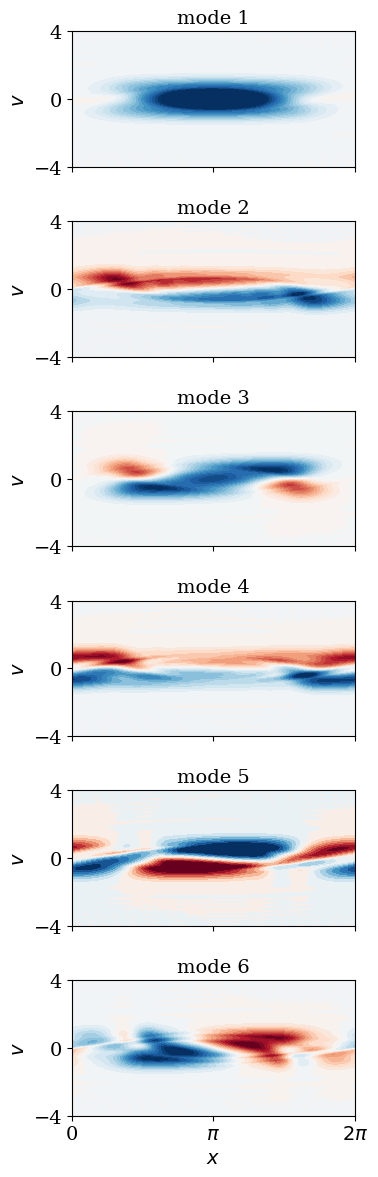

In [37]:
# plot phase space evolution 
fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(4, 12))
for tt, ii in enumerate([0, 1, 2, 3, 4, 5]):
    distribution1 = np.zeros((setup.Nx + 1, len(v)))
    distribution2 = np.zeros((setup.Nx + 1, len(v)))
    for jj in range(setup.Nv - M):
        distribution1 += np.outer(np.append(U_e1_tensor[jj, :, ii], U_e1_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e1, alpha_s=setup.alpha_e1, v=v, n=jj))
        distribution2 += np.outer(np.append(U_e2_tensor[jj, :, ii], U_e2_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e2, alpha_s=setup.alpha_e2, v=v, n=jj))
    pos = ax[tt].contourf(x, v, (distribution1 + distribution2).T, cmap="RdBu", vmax=np.max(distribution1), vmin=-np.max(distribution1), levels=30)
    ax[tt].set_ylabel("$v$")
    ax[tt].set_yticks([-4, 0, 4])
    ax[tt].set_title("mode " + str(ii + 1), fontsize=14)
    
_ = ax[-1].set_xlabel("$x$")
_ = ax[-1].set_xticks([0, np.pi, 2*np.pi])
_ = ax[-1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/POD_modes_1_M" + str(M) + ".png", dpi=200, bbox_inches='tight')

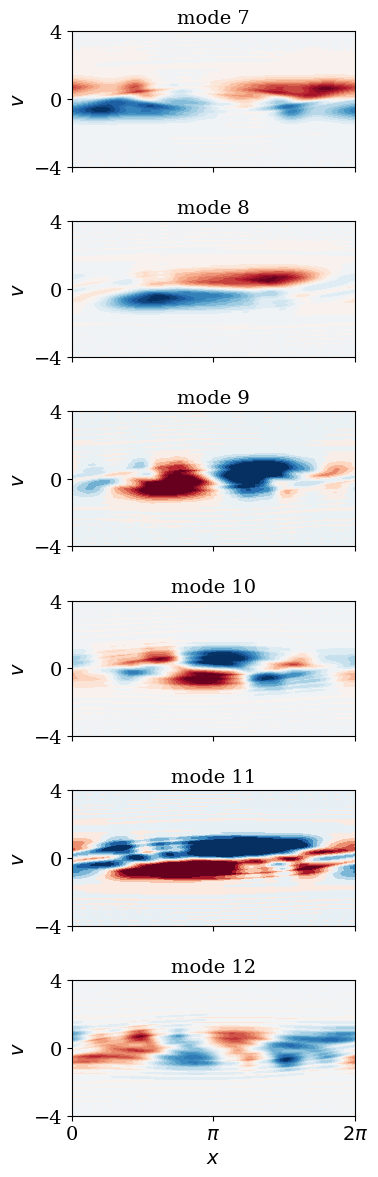

In [39]:
# plot phase space evolution 
fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(4, 12))
for tt, ii in enumerate([6, 7, 8, 9, 10, 11]):
    distribution1 = np.zeros((setup.Nx + 1, len(v)))
    distribution2 = np.zeros((setup.Nx + 1, len(v)))
    for jj in range(setup.Nv - M):
        distribution1 += np.outer(np.append(U_e1_tensor[jj, :, ii], U_e1_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e1, alpha_s=setup.alpha_e1, v=v, n=jj))
        distribution2 += np.outer(np.append(U_e2_tensor[jj, :, ii], U_e2_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e2, alpha_s=setup.alpha_e2, v=v, n=jj))
    pos = ax[tt].contourf(x, v, (distribution1 + distribution2).T, cmap="RdBu", vmax=np.max(distribution1), vmin=-np.max(distribution1), levels=30)
    ax[tt].set_ylabel("$v$")
    ax[tt].set_yticks([-4, 0, 4])
    ax[tt].set_title("mode " + str(ii + 1), fontsize=14)
    
_ = ax[-1].set_xlabel("$x$")
_ = ax[-1].set_xticks([0, np.pi, 2*np.pi])
_ = ax[-1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/POD_modes_2_M" + str(M) + ".png", dpi=200, bbox_inches='tight')

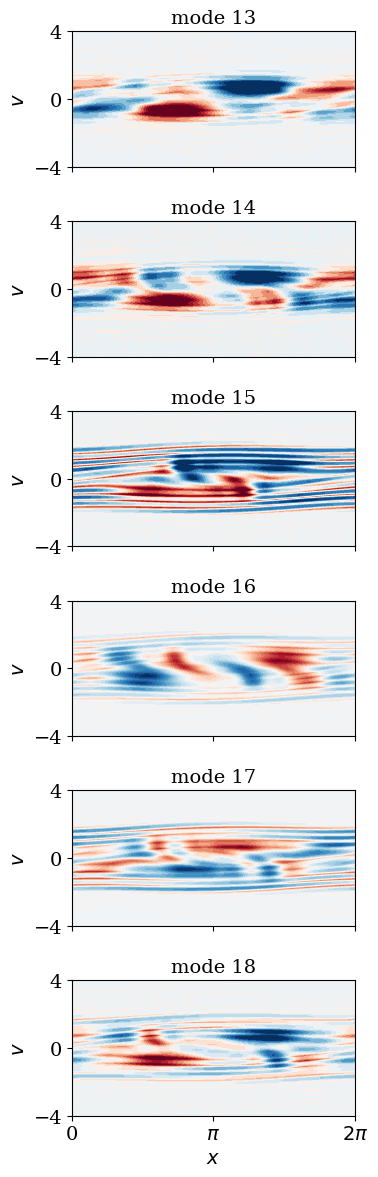

In [40]:
# plot phase space evolution 
fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(4, 12))
for tt, ii in enumerate([12, 13, 14, 15, 16, 17]):
    distribution1 = np.zeros((setup.Nx + 1, len(v)))
    distribution2 = np.zeros((setup.Nx + 1, len(v)))
    for jj in range(setup.Nv - M):
        distribution1 += np.outer(np.append(U_e1_tensor[jj, :, ii], U_e1_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e1, alpha_s=setup.alpha_e1, v=v, n=jj))
        distribution2 += np.outer(np.append(U_e2_tensor[jj, :, ii], U_e2_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e2, alpha_s=setup.alpha_e2, v=v, n=jj))
    pos = ax[tt].contourf(x, v, (distribution1 + distribution2).T, cmap="RdBu", vmax=np.max(distribution1), vmin=-np.max(distribution1), levels=30)
    ax[tt].set_ylabel("$v$")
    ax[tt].set_yticks([-4, 0, 4])
    ax[tt].set_title("mode " + str(ii + 1), fontsize=14)
    
_ = ax[-1].set_xlabel("$x$")
_ = ax[-1].set_xticks([0, np.pi, 2*np.pi])
_ = ax[-1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/POD_modes_3_M" + str(M) + ".png", dpi=200, bbox_inches='tight')